## **Measuring the Impact of Transit Access on Unemployment across Canada**

#### **An Analysis of Major Canadian Cities in 2023 and 2024**

## ***clean_transit_data.py***

In [30]:
import pandas as pd

parquet_path = "data/01-raw_data/public_transport_access.parquet"
transit_data = pd.read_parquet(parquet_path)

Functions to clean and preprocess data for Canadian cities.

In [31]:
def print_unique_values(df):
    """Prints unique values for each column in a DataFrame, showing up to 10 for columns with many unique values."""
    for col in df.columns:
        unique_vals = df[col].unique()
        num_unique = len(unique_vals)
        print(f"--- {col} ({num_unique} unique values) ---")
        if num_unique < 50:
            print(unique_vals)
        else:
            print(unique_vals[:10])
            print(f"... and {num_unique - 10} more")
        print("\n")

In [32]:
def check_id_consistency(df1, df2, id_col1, id_col2, name_col1=None, name_col2=None, label1="Dataset 1", label2="Dataset 2"):
    """
    Compares unique identifiers between two DataFrames to check for consistency.

    Args:
        df1, df2: The DataFrames to compare.
        id_col1, id_col2: The names of the ID columns to match on.
        name_col1, name_col2: (Optional) Descriptive columns to display alongside IDs. 
                              If None, only IDs are displayed.
        label1, label2: (Optional) String labels for the print output.
    """
    
    # 1. Get unique IDs as sets
    ids_1 = set(df1[id_col1].unique())
    ids_2 = set(df2[id_col2].unique())

    # 2. Find intersection and differences
    common_ids = ids_1 & ids_2
    only_in_1 = ids_1 - ids_2
    only_in_2 = ids_2 - ids_1
    
    # Helper to select columns for display
    cols_1 = [id_col1, name_col1] if name_col1 else [id_col1]
    cols_2 = [id_col2, name_col2] if name_col2 else [id_col2]

    print(f"--- COMPARISON: {label1} vs. {label2} ---\n")

    # 3. Only in Dataset 1
    print(f"IDs only in {label1}: ({len(only_in_1)})")
    if only_in_1:
        display_df = df1[df1[id_col1].isin(only_in_1)][cols_1].drop_duplicates()
        print(display_df.to_string(index=False))
    else:
        print("None")
    print("-" * 40)

    # 4. Only in Dataset 2
    print(f"IDs only in {label2}: ({len(only_in_2)})")
    if only_in_2:
        display_df = df2[df2[id_col2].isin(only_in_2)][cols_2].drop_duplicates()
        print(display_df.to_string(index=False))
    else:
        print("None")
    print("-" * 40)

    # 5. Common to both
    print(f"IDs present in BOTH: ({len(common_ids)})")
    if common_ids:
        # Defaults to showing descriptive info from DF1
        display_df = df1[df1[id_col1].isin(common_ids)][cols_1].drop_duplicates()
        print(display_df.head(10).to_string(index=False)) # Limiting to 10 rows for readability
        if len(common_ids) > 10:
            print(f"...and {len(common_ids) - 10} more.")
    else:
        print("None")

In [33]:
# 1. Identify missing values in GEO
missing_mask = transit_data['VALUE'].isna()

# Get the list of cities (GEOs) that have at least one missing value
# unique() gives us the list of names
cmas_to_drop = transit_data.loc[missing_mask, 'GEO'].unique()
print("CMAs with missing values in VALUE:")
print(cmas_to_drop)

transit_data = transit_data[~transit_data['GEO'].isin(cmas_to_drop)].copy()

CMAs with missing values in VALUE:
['Saguenay, Census metropolitan area (CMA)']


In [34]:
cols_to_keep = [
    "GEO",
    "DGUID",
    "Distance-capacity public transit service area",
    "Demographic and socio-economic",
    "Sustainable Development Goals (SDGs) 11.2.1 indicator",
    "UOM",
    "VALUE"
]
transit_data = transit_data[cols_to_keep].copy()

# Rename columns for clarity
transit_data = transit_data.rename(columns={
    "GEO": "CMA",
    "DGUID": "CMA_ID",
    "Distance-capacity public transit service area": "Transit_Distance_Category",
    "Demographic and socio-economic": "Transit_Profile_Characteristic",
    "Sustainable Development Goals (SDGs) 11.2.1 indicator": "Measure",
    "UOM": "Transit_Unit_of_Measure",
    "VALUE": "Transit_Value"
})
transit_data.head()

# Convert 'CMA' to string, remove ", Census metropolitan area (CMA)" to make it cleaner
transit_data['CMA'] = transit_data['CMA'].str.replace(", Census metropolitan area (CMA)", "", regex=False)

In [35]:
print_unique_values(transit_data)

--- CMA (41 unique values) ---
["St. John's" 'Halifax' 'Fredericton' 'Moncton' 'Saint John'
 'Drummondville' 'Montréal' 'Ottawa - Gatineau (Quebec part)' 'Québec'
 'Sherbrooke' 'Trois-Rivières' 'Barrie' 'Belleville - Quinte West'
 'Brantford' 'Greater Sudbury' 'Guelph' 'Hamilton' 'Kingston'
 'Kitchener - Cambridge - Waterloo' 'London' 'Oshawa'
 'Ottawa - Gatineau (Ontario part)' 'Peterborough'
 'St. Catharines - Niagara' 'Thunder Bay' 'Toronto' 'Windsor' 'Winnipeg'
 'Regina' 'Saskatoon' 'Calgary' 'Edmonton' 'Lethbridge' 'Red Deer'
 'Abbotsford - Mission' 'Chilliwack' 'Kamloops' 'Kelowna' 'Nanaimo'
 'Vancouver' 'Victoria']


--- CMA_ID (41 unique values) ---
['2021S0503001' '2021S0503205' '2021S0503320' '2021S0503305'
 '2021S0503310' '2021S0503447' '2021S0503462' '2021S050524505'
 '2021S0503421' '2021S0503433' '2021S0503442' '2021S0503568'
 '2021S0503522' '2021S0503543' '2021S0503580' '2021S0503550'
 '2021S0503537' '2021S0503521' '2021S0503541' '2021S0503555'
 '2021S0503532' '2021S05053

## ***clean_labour_data.py***

In [16]:
import pandas as pd

parquet_path = "data/01-raw_data/labour_rates2.parquet"
labour_data = pd.read_parquet(parquet_path)

In [17]:
check_id_consistency(
    df1=transit_data,
    df2=labour_data,
    id_col1="CMA_ID",
    id_col2="DGUID",
    name_col1="CMA",
    name_col2="GEO",
    label1="Transit Data",
    label2="Labour Data")

--- COMPARISON: Transit Data vs. Labour Data ---

IDs only in Transit Data: (1)
      CMA_ID        CMA
2021S0503001 St. John's
----------------------------------------
IDs only in Labour Data: (3)
       DGUID                                   GEO
  2021S05031 St. John's, Newfoundland and Labrador
2021S0503408                      Saguenay, Quebec
2021S0503505       Ottawa-Gatineau, Ontario/Quebec
----------------------------------------
IDs present in BOTH: (40)
        CMA_ID                             CMA
  2021S0503205                         Halifax
  2021S0503320                     Fredericton
  2021S0503305                         Moncton
  2021S0503310                      Saint John
  2021S0503447                   Drummondville
  2021S0503462                        Montréal
2021S050524505 Ottawa - Gatineau (Quebec part)
  2021S0503421                          Québec
  2021S0503433                      Sherbrooke
  2021S0503442                  Trois-Rivières
...and 30 more

To ensure consistency between datasets, we identified that the DGUID ‘2021S05031’ in the labour data corresponded to St. John’s, matching the CMA_ID ‘2021S0503001’ in the transit data. Based on this partial match in city names, we manually replaced the DGUID in the labour data to enable accurate merging.

In [18]:
# Replace DGUID value in labour_data
labour_data['DGUID'] = labour_data['DGUID'].replace('2021S05031', '2021S0503001')

No data was found for Saguenay, Quebec (DGUID ‘2021S0503408’) in the transit dataset, so this city was excluded from the analysis. 

For Ottawa-Gatineau, Ontario/Quebec (DGUID ‘2021S0503505’), the city is split into Ontario and Quebec parts in the transit data, which are already represented as separate entries; therefore, the combined DGUID was not used.

We drop this DGUID from the labour data to maintain consistency across datasets.


In [19]:
to_drop = ['2021S0503408', '2021S0503505']
labour_data = labour_data[~labour_data['DGUID'].isin(to_drop)].copy()

In [20]:
# Get unique IDs from each DataFrame
transit_ids = set(transit_data["CMA_ID"].unique())
labour_ids = set(labour_data["DGUID"].unique())

# Find common and exclusive IDs
common_ids = transit_ids & labour_ids
only_in_transit = transit_ids - labour_ids
only_in_labour = labour_ids - transit_ids

print(f"Common CMA_IDs: {len(common_ids)}")
print(f"Only in transit_data: {len(only_in_transit)}")
print(f"Only in labour_data: {len(only_in_labour)}")

Common CMA_IDs: 41
Only in transit_data: 0
Only in labour_data: 0


In [22]:
check_id_consistency(
    df1=transit_data,
    df2=labour_data,
    id_col1="CMA_ID",
    id_col2="DGUID",
    name_col1="CMA",
    name_col2="GEO",
    label1="Transit Data",
    label2="Labour Data")

--- COMPARISON: Transit Data vs. Labour Data ---

IDs only in Transit Data: (0)
None
----------------------------------------
IDs only in Labour Data: (0)
None
----------------------------------------
IDs present in BOTH: (41)
        CMA_ID                             CMA
  2021S0503001                      St. John's
  2021S0503205                         Halifax
  2021S0503320                     Fredericton
  2021S0503305                         Moncton
  2021S0503310                      Saint John
  2021S0503447                   Drummondville
  2021S0503462                        Montréal
2021S050524505 Ottawa - Gatineau (Quebec part)
  2021S0503421                          Québec
  2021S0503433                      Sherbrooke
...and 31 more.


In [ ]:
cols_to_keep = [
    "REF_DATE",
    "GEO",
    "DGUID",
    "Labour force characteristics",
    "UOM",
    "VALUE"
]
labour_data = labour_data[cols_to_keep].copy()

labour_data = labour_data.rename(columns={
    "REF_DATE": "Labour_Reference_Date",
    "GEO": "CMA",
    "DGUID": "CMA_ID",
    "Labour force characteristics": "Labour_Metric",
    "UOM": "Labour_Unit_of_Measure",
    "VALUE": "Labour_Value"
})
labour_data.head(10)

,Labour_Reference_Date,CMA,CMA_ID,Labour_Metric,Labour_Unit_of_Measure,Labour_Value
0,2023-07,"St. John's, Newfoundland and Labrador",2021S0503001,Population,Persons in thousands,195.0
1,2023-07,"St. John's, Newfoundland and Labrador",2021S0503001,Labour force,Persons in thousands,126.2
2,2023-07,"St. John's, Newfoundland and Labrador",2021S0503001,Employment,Persons in thousands,118.7
3,2023-07,"St. John's, Newfoundland and Labrador",2021S0503001,Unemployment,Persons in thousands,7.4
4,2023-07,"St. John's, Newfoundland and Labrador",2021S0503001,Unemployment rate,Percent,5.9
5,2023-07,"St. John's, Newfoundland and Labrador",2021S0503001,Participation rate,Percent,64.7
6,2023-07,"St. John's, Newfoundland and Labrador",2021S0503001,Employment rate,Percent,60.9
7,2023-07,"Halifax, Nova Scotia",2021S0503205,Population,Persons in thousands,427.1
8,2023-07,"Halifax, Nova Scotia",2021S0503205,Labour force,Persons in thousands,291.1
9,2023-07,"Halifax, Nova Scotia",2021S0503205,Employment,Persons in thousands,272.4


In [38]:
sorted(transit_data['CMA_ID'].unique()) == sorted(labour_data['CMA_ID'].unique())

True

## ***clean_commute_data.py***

In [24]:
parquet_path = "data/01-raw_data/commute_times.parquet"
commute_data = pd.read_parquet(parquet_path)

In [25]:
check_id_consistency(
    df1=transit_data,
    df2=commute_data,
    id_col1="CMA_ID",
    id_col2="DGUID",
    name_col1="CMA",
    name_col2="GEO",
    label1="Transit Data",
    label2="Commute Data")

--- COMPARISON: Transit Data vs. Commute Data ---

IDs only in Transit Data: (2)
        CMA_ID                              CMA
2021S050524505  Ottawa - Gatineau (Quebec part)
2021S050535505 Ottawa - Gatineau (Ontario part)
----------------------------------------
IDs only in Commute Data: (11)
       DGUID                                    GEO
2021S0504450                   Granby(CA) 450, Que.
2021S0504850          Grande Prairie(CA) 850, Alta.
2021S0504805            Medicine Hat(CA) 805, Alta.
2021S0504575                North Bay(CA) 575, Ont.
2021S0503505 Ottawa - Gatineau (CMA) 505, Ont./Que.
2021S0504970            Prince George(CA) 970, B.C.
2021S0503408               Saguenay (CMA) 408, Que.
2021S0504452          Saint-Hyacinthe(CA) 452, Que.
2021S0504562                   Sarnia(CA) 562, Ont.
2021S0504590         Sault Ste. Marie(CA) 590, Ont.
2021S0504860            Wood Buffalo(CA) 860, Alta.
----------------------------------------
IDs present in BOTH: (39)
      CMA_ID

In [71]:
# Get unique IDs from each DataFrame
transit_ids = set(transit_data["CMA_ID"].unique())
commute_ids = set(commute_data["DGUID"].unique())

# Find common and exclusive IDs
common_ids = transit_ids & commute_ids
only_in_transit = transit_ids - commute_ids
only_in_commmute = commute_ids - transit_ids

# Only in transit_data
print(f"CMA_IDs only in transit_data (not in commute_data): ({len(only_in_transit)})")
print(transit_data[transit_data["CMA_ID"].isin(only_in_transit)][["CMA_ID", "CMA"]].drop_duplicates())

# Only in labour_data
print(f"\nDGUIDs only in commute_data (not in transit_data): ({len(only_in_commmute)})")
print(commute_data[commute_data["DGUID"].isin(only_in_commmute)][["DGUID", "GEO"]].drop_duplicates())

# Present in both
print(f"\nCMA_IDs/DGUIDs present in both datasets: ({len(common_ids)})")
print(transit_data[transit_data["CMA_ID"].isin(common_ids)][["CMA_ID", "CMA"]].drop_duplicates())

CMA_IDs only in transit_data (not in commute_data): (2)
              CMA_ID                               CMA
616   2021S050524505   Ottawa - Gatineau (Quebec part)
1936  2021S050535505  Ottawa - Gatineau (Ontario part)

DGUIDs only in commute_data (not in transit_data): (11)
             DGUID                                     GEO
417   2021S0504450                    Granby(CA) 450, Que.
460   2021S0504850           Grande Prairie(CA) 850, Alta.
964   2021S0504805             Medicine Hat(CA) 805, Alta.
1147  2021S0504575                 North Bay(CA) 575, Ont.
1237  2021S0503505  Ottawa - Gatineau (CMA) 505, Ont./Que.
1332  2021S0504970             Prince George(CA) 970, B.C.
1514  2021S0503408                Saguenay (CMA) 408, Que.
1605  2021S0504452           Saint-Hyacinthe(CA) 452, Que.
1650  2021S0504562                    Sarnia(CA) 562, Ont.
1742  2021S0504590          Sault Ste. Marie(CA) 590, Ont.
2252  2021S0504860             Wood Buffalo(CA) 860, Alta.

CMA_IDs/DGUID

In [26]:
unified_dguid = '2021S0503505'
id_quebec_part = '2021S050524505'
id_ontario_part = '2021S050535505'


# --- 1. Isolate ALL rows for the unified DGUID ---
ottawa_unified_rows = commute_data[commute_data['DGUID'] == unified_dguid].copy()

# --- 2. Create the two split datasets ---

# Copy 1: Quebec Part
ottawa_quebec_part = ottawa_unified_rows.copy()
# Assign the new ID and update the GEO description
ottawa_quebec_part['DGUID'] = id_quebec_part
ottawa_quebec_part['GEO'] = 'Ottawa-Gatineau, Quebec part, Ontario/Quebec'

# Copy 2: Ontario Part
ottawa_ontario_part = ottawa_unified_rows.copy()
# Assign the new ID and update the GEO description
ottawa_ontario_part['DGUID'] = id_ontario_part
ottawa_ontario_part['GEO'] = 'Ottawa-Gatineau, Ontario part, Ontario/Quebec'

# --- 3. Combine the new split datasets ---
ottawa_split_data = pd.concat([ottawa_quebec_part, ottawa_ontario_part])

# --- 4. Remove the original rows and add the new ones ---

# Filter out the original unified DGUID rows from the main DataFrame
commute_data_filter = commute_data[commute_data['DGUID'] != unified_dguid].copy()

# Concatenate the filtered data with the newly created split data
commute_data = pd.concat([commute_data_filter, ottawa_split_data])

In [27]:
check_id_consistency(
    df1=transit_data,
    df2=commute_data,
    id_col1="CMA_ID",
    id_col2="DGUID",
    name_col1="CMA",
    name_col2="GEO",
    label1="Transit Data",
    label2="Commute Data")

--- COMPARISON: Transit Data vs. Commute Data ---

IDs only in Transit Data: (0)
None
----------------------------------------
IDs only in Commute Data: (10)
       DGUID                            GEO
2021S0504450           Granby(CA) 450, Que.
2021S0504850  Grande Prairie(CA) 850, Alta.
2021S0504805    Medicine Hat(CA) 805, Alta.
2021S0504575        North Bay(CA) 575, Ont.
2021S0504970    Prince George(CA) 970, B.C.
2021S0503408       Saguenay (CMA) 408, Que.
2021S0504452  Saint-Hyacinthe(CA) 452, Que.
2021S0504562           Sarnia(CA) 562, Ont.
2021S0504590 Sault Ste. Marie(CA) 590, Ont.
2021S0504860    Wood Buffalo(CA) 860, Alta.
----------------------------------------
IDs present in BOTH: (41)
        CMA_ID                             CMA
  2021S0503001                      St. John's
  2021S0503205                         Halifax
  2021S0503320                     Fredericton
  2021S0503305                         Moncton
  2021S0503310                      Saint John
  2021S05

In [29]:
cols_to_keep = [
    "GEO",
    "DGUID",
    "Main mode of commuting (21)",
    "Commuting duration (7)",
    "VALUE"
]
commute_data = commute_data[cols_to_keep].copy()

commute_data = commute_data.rename(columns={
    "GEO": "CMA",
    "DGUID": "CMA_ID",
    "Main mode of commuting (21)": "Commute_Mode",
    "Commuting duration (7)": "Commute_Duration",
    "VALUE": "Commute_Value"
})
commute_data.head()

,CMA,CMA_ID,Commute_Mode,Commute_Duration,Commute_Value
0,"Abbotsford - Mission (CMA) 932, B.C.",2021S0503932,Total - Main mode of commuting,Total - Commuting duration,55335.0
1,"Abbotsford - Mission (CMA) 932, B.C.",2021S0503932,Total - Main mode of commuting,Less than 15 minutes,23435.0
2,"Abbotsford - Mission (CMA) 932, B.C.",2021S0503932,Total - Main mode of commuting,15 to 29 minutes,18680.0
3,"Abbotsford - Mission (CMA) 932, B.C.",2021S0503932,Total - Main mode of commuting,30 to 44 minutes,8640.0
4,"Abbotsford - Mission (CMA) 932, B.C.",2021S0503932,Total - Main mode of commuting,45 to 59 minutes,2885.0


We now have three datasets cleaned and ready for analysis: transit access, unemployment rates, and commute times. The next step is to merge these datasets based on the common city identifiers to conduct an analysis of how transit access impacts unemployment rates across Canadian cities.

## ***analysis_data.py***

Pivot each dataset into a wide format for analysis and merging.

In [ ]:
# --- 1. Clean and Prepare Date/Value Columns ---

# Convert the REF_DATE to a datetime object
labour_data['Reference_Date'] = pd.to_datetime(labour_data['Labour_Reference_Date'])

# Extract the year (for grouping, though it will be '2024' for all)
labour_data['Year'] = labour_data['Reference_Date'].dt.year

# Ensure Labour_Value is numeric (essential for calculation)
# We will coerce errors to NaN, which should be dropped later if necessary
labour_data['Labour_Value'] = pd.to_numeric(
    labour_data['Labour_Value'], errors='coerce'
)

# --- 2. Calculate Annual Average for ALL Labour Metrics ---

# Group by CMA_ID, CMA, Year, and Labour_Metric, then calculate the mean (annual average)
labour_annual_avg = labour_data.groupby(
    ['CMA_ID', 'CMA', 'Labour_Metric']
)['Labour_Value'].mean().reset_index()

# Rename the aggregated column
labour_annual_avg.rename(
    columns={'Labour_Value': 'Annual_Avg_Labour_Value'},
    inplace=True
)

# --- 3. Pivot the Aggregated Data ---

# Pivot the table to make each Labour_Metric a column, resulting in one row per CMA
labour_final_pivoted = labour_annual_avg.pivot(
    index='CMA_ID',
    columns='Labour_Metric',
    values='Annual_Avg_Labour_Value'
).reset_index()

# Clean up column names (e.g., remove spaces or special characters for regression)
labour_final_pivoted.columns.name = None 

# Example of necessary renames for the regression model variables:
labour_final_pivoted.rename(columns={
    'Unemployment rate': 'Unemployment_Rate',
    'Participation rate': 'Participation_Rate',
    'Employment': 'Employment_Avg_Thousands' # Example rename
}, inplace=True)

print("--- Final Labour Data Aggregated and Pivoted (Sample) ---")
print(labour_final_pivoted.head())

--- Final Labour Data Aggregated and Pivoted (Sample) ---
         CMA_ID  Employment_Avg_Thousands  Employment rate  Labour force  \
0  2021S0503001                     118.7             60.9         126.2   
1  2021S0503205                     272.4             63.8         291.1   
2  2021S0503305                      92.8             62.9          97.9   
3  2021S0503310                      67.0             57.8          70.7   
4  2021S0503320                      58.3             59.7          61.0   

   Participation_Rate  Population  Unemployment  Unemployment_Rate  
0                64.7       195.0           7.4                5.9  
1                68.2       427.1          18.7                6.4  
2                66.4       147.5           5.1                5.2  
3                61.0       115.9           3.7                5.2  
4                62.4        97.7           2.7                4.4  


In [64]:
labour_final_pivoted.Unemployment_Rate.describe()

count    41.000000
mean      5.097561
std       1.288116
min       2.800000
25%       4.400000
50%       5.000000
75%       5.900000
max       9.800000
Name: Unemployment_Rate, dtype: float64

In [67]:
print_unique_values(labour_data)

--- Labour_Reference_Date (1 unique values) ---
['2023-07']


--- CMA (41 unique values) ---
["St. John's, Newfoundland and Labrador" 'Halifax, Nova Scotia'
 'Moncton, New Brunswick' 'Saint John, New Brunswick'
 'Fredericton, New Brunswick' 'Québec, Quebec' 'Sherbrooke, Quebec'
 'Trois-Rivières, Quebec' 'Drummondville, Québec' 'Montréal, Quebec'
 'Ottawa-Gatineau, Quebec part, Ontario/Quebec'
 'Ottawa-Gatineau, Ontario part, Ontario/Quebec' 'Kingston, Ontario'
 'Belleville - Quinte West, Ontario' 'Peterborough, Ontario'
 'Oshawa, Ontario' 'Toronto, Ontario' 'Hamilton, Ontario'
 'St. Catharines-Niagara, Ontario' 'Kitchener-Cambridge-Waterloo, Ontario'
 'Brantford, Ontario' 'Guelph, Ontario' 'London, Ontario'
 'Windsor, Ontario' 'Barrie, Ontario' 'Greater Sudbury, Ontario'
 'Thunder Bay, Ontario' 'Winnipeg, Manitoba' 'Regina, Saskatchewan'
 'Saskatoon, Saskatchewan' 'Lethbridge, Alberta' 'Calgary, Alberta'
 'Red Deer, Alberta' 'Edmonton, Alberta' 'Kelowna, British Columbia'
 'Kamloops, B

In [68]:
labour_final_pivoted.head(5)

,CMA_ID,Employment_Avg_Thousands,Employment rate,Labour force,Participation_Rate,Population,Unemployment,Unemployment_Rate
0,2021S0503001,118.7,60.9,126.2,64.7,195.0,7.4,5.9
1,2021S0503205,272.4,63.8,291.1,68.2,427.1,18.7,6.4
2,2021S0503305,92.8,62.9,97.9,66.4,147.5,5.1,5.2
3,2021S0503310,67.0,57.8,70.7,61.0,115.9,3.7,5.2
4,2021S0503320,58.3,59.7,61.0,62.4,97.7,2.7,4.4


## **analysis_data.py** for merging datasets

In [228]:
# 1. Prepare transit_data: Drop the less specific 'CMA' column from the transit data
#    to keep the more detailed CMA name from the labour data.
transit_data_clean = transit_data.drop(columns=['CMA'])

# 2. Perform the merge: Join the two dataframes on the unique geographic ID.
#    Using 'inner' ensures you only include cities present in both datasets.
transit_labour_analysis = pd.merge(
    labour_data,
    transit_data_clean,
    on='CMA_ID',
    how='inner'
)

print(transit_labour_analysis.info())
print("\nFirst 5 rows of the merged data:")
print(transit_labour_analysis.head())
transit_labour_analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303072 entries, 0 to 303071
Data columns (total 13 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Labour_Reference_Date           303072 non-null  object        
 1   CMA                             303072 non-null  object        
 2   CMA_ID                          303072 non-null  object        
 3   Labour_Metric                   303072 non-null  object        
 4   Labour_Unit_of_Measure          303072 non-null  object        
 5   Labour_Value                    303072 non-null  float64       
 6   Reference_Date                  303072 non-null  datetime64[ns]
 7   Year                            303072 non-null  int32         
 8   Transit_Distance_Category       303072 non-null  object        
 9   Transit_Profile_Characteristic  303072 non-null  object        
 10  Measure                         303072 non-null  object 

,Labour_Reference_Date,CMA,CMA_ID,Labour_Metric,Labour_Unit_of_Measure,Labour_Value,Reference_Date,Year,Transit_Distance_Category,Transit_Profile_Characteristic,Measure,Transit_Unit_of_Measure,Transit_Value
0,2023-01,"St. John's, Newfoundland and Labrador",2021S0503001,Population,Persons in thousands,191.5,2023-01-01,2023,400 metres from all public transit stops,Total - Age groups of the population - 100% data,Count of population within service area,Persons,104585.0
1,2023-01,"St. John's, Newfoundland and Labrador",2021S0503001,Population,Persons in thousands,191.5,2023-01-01,2023,400 metres from all public transit stops,Total - Age groups of the population - 100% data,Proportion of population within service area,Percent,49.2
2,2023-01,"St. John's, Newfoundland and Labrador",2021S0503001,Population,Persons in thousands,191.5,2023-01-01,2023,400 metres from all public transit stops,0 to 14 years,Count of population within service area,Persons,12865.0
3,2023-01,"St. John's, Newfoundland and Labrador",2021S0503001,Population,Persons in thousands,191.5,2023-01-01,2023,400 metres from all public transit stops,0 to 14 years,Proportion of population within service area,Percent,40.8
4,2023-01,"St. John's, Newfoundland and Labrador",2021S0503001,Population,Persons in thousands,191.5,2023-01-01,2023,400 metres from all public transit stops,15 to 64 years,Count of population within service area,Persons,70045.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
303067,2023-12,"Nanaimo, British Columbia",2021S0503938,Employment rate,Percent,60.1,2023-12-01,2023,500 metres from low-capacity public transit st...,Employed,Proportion of population within service area,Percent,69.5
303068,2023-12,"Nanaimo, British Columbia",2021S0503938,Employment rate,Percent,60.1,2023-12-01,2023,500 metres from low-capacity public transit st...,Unemployed,Count of population within service area,Persons,3465.0
303069,2023-12,"Nanaimo, British Columbia",2021S0503938,Employment rate,Percent,60.1,2023-12-01,2023,500 metres from low-capacity public transit st...,Unemployed,Proportion of population within service area,Percent,72.3
303070,2023-12,"Nanaimo, British Columbia",2021S0503938,Employment rate,Percent,60.1,2023-12-01,2023,500 metres from low-capacity public transit st...,Not in the labour force,Count of population within service area,Persons,25945.0


In [237]:
# 1. Prepare transit_data: Drop the less specific 'CMA' column from the transit data
#    to keep the more detailed CMA name from the labour data.
commute_data_clean = commute_data.drop(columns=['CMA'])

# 2. Perform the merge: Join the two dataframes on the unique geographic ID.
#    Using 'inner' ensures you only include cities present in both datasets.
analysis_data = pd.merge(
    transit_labour_analysis,
    commute_data_clean,
    on='CMA_ID',
    how='inner'
)

print(analysis_data.info())
print("\nFirst 5 rows of the merged data:")
print(analysis_data.head())
analysis_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14089152 entries, 0 to 14089151
Data columns (total 16 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   Labour_Reference_Date           object        
 1   CMA                             object        
 2   CMA_ID                          object        
 3   Labour_Metric                   object        
 4   Labour_Unit_of_Measure          object        
 5   Labour_Value                    float64       
 6   Reference_Date                  datetime64[ns]
 7   Year                            int32         
 8   Transit_Distance_Category       object        
 9   Transit_Profile_Characteristic  object        
 10  Measure                         object        
 11  Transit_Unit_of_Measure         object        
 12  Transit_Value                   float64       
 13  Commute_Mode                    object        
 14  Commute_Duration                object        
 

,Labour_Reference_Date,CMA,CMA_ID,Labour_Metric,Labour_Unit_of_Measure,Labour_Value,Reference_Date,Year,Transit_Distance_Category,Transit_Profile_Characteristic,Measure,Transit_Unit_of_Measure,Transit_Value,Commute_Mode,Commute_Duration,Commute_Value
0,2023-01,"St. John's, Newfoundland and Labrador",2021S0503001,Population,Persons in thousands,191.5,2023-01-01,2023,400 metres from all public transit stops,Total - Age groups of the population - 100% data,Count of population within service area,Persons,104585.0,Total - Main mode of commuting,Total - Commuting duration,72160.0
1,2023-01,"St. John's, Newfoundland and Labrador",2021S0503001,Population,Persons in thousands,191.5,2023-01-01,2023,400 metres from all public transit stops,Total - Age groups of the population - 100% data,Count of population within service area,Persons,104585.0,Total - Main mode of commuting,Less than 15 minutes,31665.0
2,2023-01,"St. John's, Newfoundland and Labrador",2021S0503001,Population,Persons in thousands,191.5,2023-01-01,2023,400 metres from all public transit stops,Total - Age groups of the population - 100% data,Count of population within service area,Persons,104585.0,Total - Main mode of commuting,15 to 29 minutes,31595.0
3,2023-01,"St. John's, Newfoundland and Labrador",2021S0503001,Population,Persons in thousands,191.5,2023-01-01,2023,400 metres from all public transit stops,Total - Age groups of the population - 100% data,Count of population within service area,Persons,104585.0,Total - Main mode of commuting,30 to 44 minutes,5545.0
4,2023-01,"St. John's, Newfoundland and Labrador",2021S0503001,Population,Persons in thousands,191.5,2023-01-01,2023,400 metres from all public transit stops,Total - Age groups of the population - 100% data,Count of population within service area,Persons,104585.0,Total - Main mode of commuting,45 to 59 minutes,1310.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14089147,2023-12,"Nanaimo, British Columbia",2021S0503938,Employment rate,Percent,60.1,2023-12-01,2023,500 metres from low-capacity public transit st...,Not in the labour force,Proportion of population within service area,Percent,67.6,Other method,15 to 29 minutes,100.0
14089148,2023-12,"Nanaimo, British Columbia",2021S0503938,Employment rate,Percent,60.1,2023-12-01,2023,500 metres from low-capacity public transit st...,Not in the labour force,Proportion of population within service area,Percent,67.6,Other method,30 to 44 minutes,30.0
14089149,2023-12,"Nanaimo, British Columbia",2021S0503938,Employment rate,Percent,60.1,2023-12-01,2023,500 metres from low-capacity public transit st...,Not in the labour force,Proportion of population within service area,Percent,67.6,Other method,45 to 59 minutes,10.0
14089150,2023-12,"Nanaimo, British Columbia",2021S0503938,Employment rate,Percent,60.1,2023-12-01,2023,500 metres from low-capacity public transit st...,Not in the labour force,Proportion of population within service area,Percent,67.6,Other method,60 minutes and over,20.0


# MODEL CREATION

In [238]:
for col in analysis_data.columns:
    unique_vals = analysis_data[col].unique()
    num_unique = len(unique_vals)
    print(f"--- {col} ({num_unique} unique values) ---")
    if num_unique < 50:
        print(unique_vals)
    else:
        # For columns with many unique values, show just the first 10
        print(unique_vals[:10])
        print(f"... and {num_unique - 10} more")
    print("\n")

--- Labour_Reference_Date (12 unique values) ---
['2023-01' '2023-02' '2023-03' '2023-04' '2023-05' '2023-06' '2023-07'
 '2023-08' '2023-09' '2023-10' '2023-11' '2023-12']


--- CMA (41 unique values) ---
["St. John's, Newfoundland and Labrador" 'Halifax, Nova Scotia'
 'Moncton, New Brunswick' 'Saint John, New Brunswick'
 'Fredericton, New Brunswick' 'Québec, Quebec' 'Sherbrooke, Quebec'
 'Trois-Rivières, Quebec' 'Drummondville, Québec' 'Montréal, Quebec'
 'Ottawa-Gatineau, Quebec part, Ontario/Quebec'
 'Ottawa-Gatineau, Ontario part, Ontario/Quebec' 'Kingston, Ontario'
 'Belleville - Quinte West, Ontario' 'Peterborough, Ontario'
 'Oshawa, Ontario' 'Toronto, Ontario' 'Hamilton, Ontario'
 'St. Catharines-Niagara, Ontario' 'Kitchener-Cambridge-Waterloo, Ontario'
 'Brantford, Ontario' 'Guelph, Ontario' 'London, Ontario'
 'Windsor, Ontario' 'Barrie, Ontario' 'Greater Sudbury, Ontario'
 'Thunder Bay, Ontario' 'Winnipeg, Manitoba' 'Regina, Saskatchewan'
 'Saskatoon, Saskatchewan' 'Lethbridge

In [239]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np

# ASSUMPTION: Your single, long-format DataFrame is loaded as 'analysis_df'
# Example: analysis_df = pd.read_csv('analysis_data.csv')

analysis_df = analysis_data.copy()
# --- 1. Prepare LABOUR DATA (Y and Control X4) ---

print("--- 1. Preparing Labour Metrics (Y and Participation Rate) ---")

# Filter and pivot Labour Metrics: Unemployment Rate (Y) and Participation Rate (X4)
labour_metrics = ['Unemployment rate', 'Participation rate']
labour_pivoted = labour_data[
    (labour_data['Labour_Metric'].isin(labour_metrics)) &
    (labour_data['Labour_Unit_of_Measure'] == 'Percent')
].pivot(index='CMA_ID', columns='Labour_Metric', values='Labour_Value').reset_index()

# Rename columns clearly
labour_pivoted.rename(columns={
    'Unemployment rate': 'Unemployment_Rate',
    'Participation rate': 'Participation_Rate'
}, inplace=True)


# --- 2. Prepare TRANSIT ACCESS DATA (X1 and X3) ---

print("--- 2. Preparing Transit Access Proportions (X_Employed, X_Unemployed) ---")

# Filter and pivot Transit Proportions: Employed (X1) and Unemployed (X3)
transit_chars = ['Total - Age groups of the population - 100% data','Employed', 'Unemployed']
transit_pivoted = transit_data[
    (transit_data['Transit_Profile_Characteristic'].isin(transit_chars)) &
    (transit_data['Measure'] == 'Proportion of population within service area') &
    (transit_data['Transit_Distance_Category'] == '500 metres from all public transit stops')
].pivot(index='CMA_ID', columns='Transit_Profile_Characteristic', values='Transit_Value').reset_index()
transit_pivoted

# Rename columns clearly
transit_pivoted.rename(columns={
    'Total - Age groups of the population - 100% data': 'X_Total_Population',  # Total Population near Transit
    'Employed': 'X_Employed',          # Proportion Employed near Transit
    'Unemployed': 'X_Unemployed'      # Proportion Unemployed near Transit
}, inplace=True)

transit_pivoted

--- 1. Preparing Labour Metrics (Y and Participation Rate) ---


ValueError: Index contains duplicate entries, cannot reshape

In [ ]:

# --- 3. Prepare COMMUTE TIME DATA (X2) ---

print("--- 3. Preparing Commute Time Metric (X_Transit_Time) ---")

# Filter for Average Commuting Duration for Public Transit
commute_pivoted = commute_data[
    (commute_data['Commute_Mode'] == 'Public transit') &
    (commute_data['Commute_Duration'] == 'Average commuting duration (in minutes)')
].pivot(index='CMA_ID', columns='Commute_Duration', values='Commute_Value').reset_index()

# Rename column
commute_pivoted.rename(columns={'Average commuting duration (in minutes)': 'X_Transit_Time'}, inplace=True)
commute_pivoted

--- 3. Preparing Commute Time Metric (X_Transit_Time) ---


Commute_Duration,CMA_ID,X_Transit_Time
0,2021S0503001,32.2
1,2021S0503205,35.7
2,2021S0503305,32.2
3,2021S0503310,26.4
4,2021S0503320,28.9
5,2021S0503408,28.4
6,2021S0503421,32.0
7,2021S0503433,28.7
8,2021S0503442,31.2
9,2021S0503447,26.2


In [ ]:

# --- 4. MERGE ALL DATASETS ---

print("--- 4. Merging DataFrames ---")

# Merge Labour and Transit data
final_model_data = pd.merge(labour_pivoted, transit_pivoted, on='CMA_ID', how='inner')
# Merge Commute data
final_model_data = pd.merge(final_model_data, commute_pivoted, on='CMA_ID', how='inner')

# Ensure all columns are numeric and drop rows with any missing values for a clean regression
numeric_cols = ['Unemployment_Rate', 'Participation_Rate', 'X_Employed', 'X_Unemployed', 'X_Transit_Time', 'X_Total_Population']
for col in numeric_cols:
    final_model_data[col] = pd.to_numeric(final_model_data[col], errors='coerce')

final_model_data = final_model_data.dropna(subset=numeric_cols)

print(f"\nTotal CMAs ready for Regression: {len(final_model_data)}")

--- 4. Merging DataFrames ---

Total CMAs ready for Regression: 41


In [ ]:
# --- 5. Run the OLS Regression ---

print("\n--- 5. Running OLS Regression ---")

# Define the regression formula: Y ~ X1 + X2 + X3 + X4
formula = 'Unemployment_Rate ~ X_Employed '

# Fit the model
model = smf.ols(formula=formula, data=final_model_data)
results = model.fit()

# --- 6. Display Results ---

print("\n--- Regression Results Summary ---")
print(results.summary())


--- 5. Running OLS Regression ---

--- Regression Results Summary ---
                            OLS Regression Results                            
Dep. Variable:      Unemployment_Rate   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     2.119
Date:                Sun, 07 Dec 2025   Prob (F-statistic):              0.154
Time:                        18:57:10   Log-Likelihood:                -66.966
No. Observations:                  41   AIC:                             137.9
Df Residuals:                      39   BIC:                             141.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

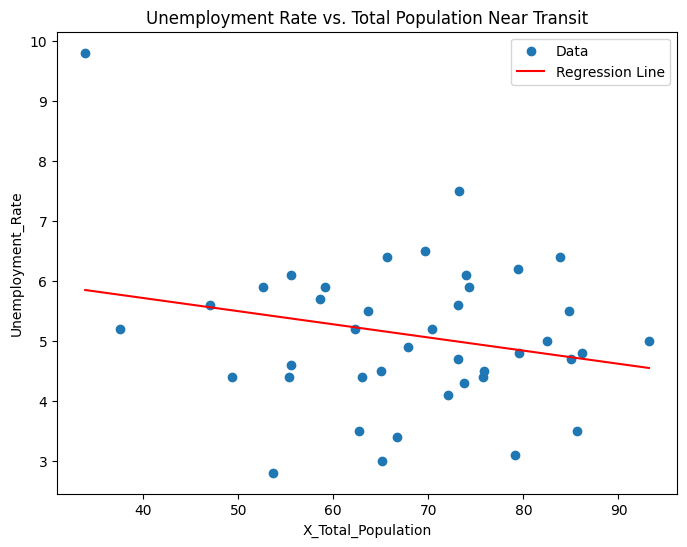

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,6))
plt.scatter(final_model_data['X_Employed'], final_model_data['Unemployment_Rate'], label='Data')

# Predicted regression line
x_vals = np.linspace(final_model_data['X_Employed'].min(), final_model_data['X_Employed'].max(), 100)
y_pred = results.params['Intercept'] + results.params['X_Employed'] * x_vals
plt.plot(x_vals, y_pred, color='red', label='Regression Line')

plt.xlabel('X_Total_Population')
plt.ylabel('Unemployment_Rate')
plt.title('Unemployment Rate vs. Total Population Near Transit')
plt.legend()
plt.show()

In [ ]:
final_model_data

,CMA_ID,Participation_Rate,Unemployment_Rate,X_Employed,X_Total_Population,X_Unemployed,X_Transit_Time
0,2021S0503001,64.7,5.9,52.6,54.5,56.7,32.2
1,2021S0503205,68.2,6.4,65.6,65.5,71.4,35.7
2,2021S0503305,66.4,5.2,62.3,62.6,65.4,32.2
3,2021S0503310,61.0,5.2,37.6,39.7,47.5,26.4
4,2021S0503320,62.4,4.4,49.3,48.5,54.6,28.9
5,2021S0503421,66.4,3.1,79.1,80.1,84.4,32.0
6,2021S0503433,58.5,3.5,62.7,63.7,68.1,28.7
7,2021S0503442,58.6,4.1,72.1,73.8,76.7,31.2
8,2021S0503447,64.5,2.8,53.7,56.4,64.1,26.2
9,2021S0503462,68.8,4.7,85.0,85.8,89.8,43.1
